# Experimenting with NASA's Nearest-Earth-Objects (NEOs) Data Set

Video presentation: https://drive.google.com/drive/folders/1JLkXEEBZdRoK3PhLWg4jSnzT_EpSR0ue?usp=sharing

The dataset, available on [Kaggle](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects/data), provides information on nearest-Earth objects (NEOs) discovered from January 1, 2001, to June 14, 2022, sourced directly from the Center for Near-Earth Object Studies (CNEOS) and hosted by NASA’s Jet Propulsion Laboratory. 

Given the characteristics of the dataset and its features, a straightforward approach for a machine learning model is to predict whether an object is hazardous to Earth using classification. This is feasible due to the inherent nature of the `Hazardous` feature as a Boolean.  Represented by `true` or `false` values, it supports the translation of these values to classification labels $𝑦,𝑦̂∈[0,1]$ for binary classification.  



In [1]:
target = 'hazardous'
random_state=0

## Installing Required Dependencies 

In order to begin experimenting with the data set, certain Python packages need to be installed. These packages include libraries for data manipulation, visualization, and machine learning. Packages are installed using the `pip` package manager.

In [2]:
# First things is first: Download all dependencies

! pip install plotly seaborn scikit-learn kaggle numpy matplotlib pandas pathlib scipy imbalanced-learn

In [3]:
# Next, import everything that you need. Or may need. Better safe than sorry

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import sklearn as sk
import zipfile as zp
import pathlib as pl

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRFClassifier

## Downloading the Data Set

In [4]:
# And now for the lovely dataset

dl_dir = pl.Path() / 'data'
dl_dir.mkdir(parents=True, exist_ok=True)

file_path = dl_dir / 'nasa-nearest-earth-objects.zip'

if file_path.exists():
    print('Files already extracted at the specified location.')
else:
    ! kaggle datasets download -d sameepvani/nasa-nearest-earth-objects --force -p  {dl_dir}
    with zp.ZipFile(file_path , 'r') as zip_ref:
        zip_ref.extractall(dl_dir)

Files already extracted at the specified location.


In [5]:
# Renaming file path and defining the dataframe

file_path = pl.Path(dl_dir) / 'neo.csv'

df = pd.read_csv(file_path)

## Data Set Overview

In [6]:
# Hopfully this worked

df.info()
# If you get an output from that shows the informaiton of the dataset, congrats. You have now completed
# step 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


### Head

In [7]:
# Now time to explore the dataset, see what's up

df.head(n = 10) # look at the first 10 entries of the dataset. Remember this is index counting.

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
5,54138696,(2021 GY23),0.036354,0.081291,34297.587778,4.058569e+07,Earth,False,24.32,False
6,54189957,(2021 PY40),0.171615,0.383743,27529.472307,2.906912e+07,Earth,False,20.95,False
7,54230078,(2021 XD6),0.005328,0.011914,57544.470083,5.511502e+07,Earth,False,28.49,False
8,2088213,88213 (2001 AF2),0.350393,0.783502,56625.210122,6.903598e+07,Earth,False,19.40,False
9,3766065,(2016 YM),0.105817,0.236614,48425.840329,3.835526e+07,Earth,False,22.00,False


### Info

In [8]:
# Checking for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


#### Checking for Null Values

This confirms there are no missing values in the data set and the data types are correct. 

In [9]:
df.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

## Helper Functions

Functions to handle the miscellaneous operations for visualizing the data set. These functions will be used to visualize any changes from preprocessing actions. 


In [10]:
# Fun with functions.
# We're going to write some functions that will help with data analysis

# Function: Save Figure
def save_fig(fig_id, fig_dir = pl.Path() / 'figures', tight_layout = True, fig_extension = 'png', resolution = 300):
    if not fig_dir.exists():
        fig_dir.mkdir(parents = True, exist_ok = True)
    path = fig_dir / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

In [11]:
# Class Distribution Plot
def class_dist_plot(df, target):
    class_counts = df[target].value_counts()
    class_counts.plot(kind = 'bar', rot = 0)
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.title('Class Distribution')

In [12]:
#Scatter Plot
def scatter_plot(df, x_col, y_col, hue_col = None):
    plt.figure(figsize=(20,20))
    if hue_col:
        sns.scatterplot(data = df, x = x_col, y = y_col, hue = hue_col, alpha = 0.7)
    else:
        plt.scatter(df[x_col], df[y_col], alpha = 0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{x_col} vs {y_col}')
    plt.legend(title = hue_col)
    plt.show()

In [13]:
units = {
    'estimated_average_diameter': 'kilometers',
    'relative_velocity': 'km/s',
    'miss_distance': 'kilometers',
    'absolute_magnitude': 'mag'
}

plt.figure(figsize=(10,10))

# Formatting Columns Labels
def format_column_label(col):
    return col.replce('_', ' ').title()

label_font_size = 9
title_font_size = 10
ticks_font_size = 8

#Barplot Variables vs Target
def barplot_variables_vs_target(df, target, units):
    features = [col for col in df.columns if col != target]

    num_cols = len(features)
    num_rows = (num_cols + 1) // 2

    for i, col in enumerate(features, 1):
        y_label = f"{format_column_label(col)}\n({units.get(col, '')})"
        plt.subplot(num_cols, num_rows, i)
        sns.barplot(data = df, x = target, y = col, hue = target, legend = False)
        plt.xlabel(target.capitalize(), fontsize = label_font_size)
        plt.ylabel(y_label, fontsize = label_font_size)
        plt.xticks(fontsize = ticks_font_size)
        plt.yticks(fontsize = ticks_font_size)
        plt.tight_layout()
    
    plt.suptitle(f'Variables vs {target.capitalize()}', fontsize = title_font_size, y = 1.02)
    plt.show()

<Figure size 1000x1000 with 0 Axes>

In [14]:
#XY Graph from the datafram, defined as df

def plot_xy_from_df(df, x_col, y_col, hue_col = None, ylim = None):
    plt.figure(figsize=(20,20))
    if hue_col:
        sns.scatterplot(data = df, x = x_col, y = y_col, hue = hue_col, alpha = 0.7)
    else:
        plt.scatter(df[x_col], df[y_col], alpha = 0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.ylim(0, ylim)
    plt.title(f'{x_col} vs {y_col}')
    plt.legend(title = hue_col)
    plt.show()

In [15]:
#Pair Plot function
def pair_plot(df, target):
    return sns.pairplot(df, hue = target)

In [16]:
#Heat Map function
def heat_map(df):
    return sns.heatmap(df.corr(), annot=True, linewidths=0.5)

In [17]:
#Correlation function. This one gave me a problem earlier
def corr_sort(df, target, method='pearson'):
    corr_ = df.corr(method = method)
    return corr_[target].sort_values(ascending = False)

In [18]:
#drop function
def drop(df, *features):
    return df.copy().drop(columns=list(features))

In [19]:
#Logorithmic Transformation
def log_transform_feature(df, feature_name):
    df_transformed = df.copy()
    df_transformed[feature_name] = np.log(df_transformed[feature_name])
    return df_transformed

## Visualizing and Exploring the Data

### Class Distribution

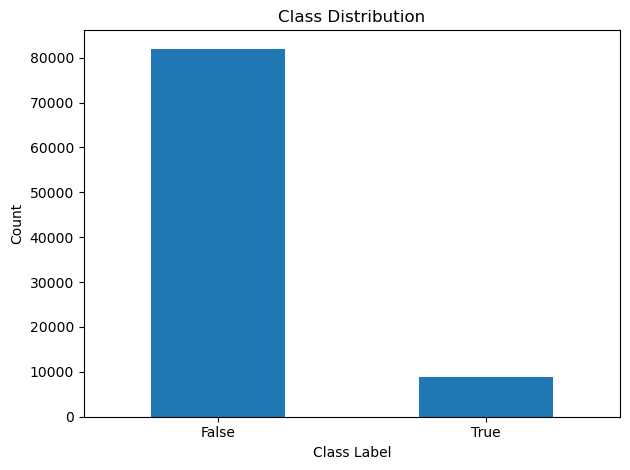

In [20]:
# time for our first graph. To see how many near earth objects in the dataset are considered hazardous

class_dist_plot(df, target)
save_fig('class_distribution_plot')

### Correlation Matrix

C:\Users\Clay\AppData\Local\Temp\ipykernel_4776\2224523809.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return sns.heatmap(df.corr(), annot=True, linewidths=0.5)


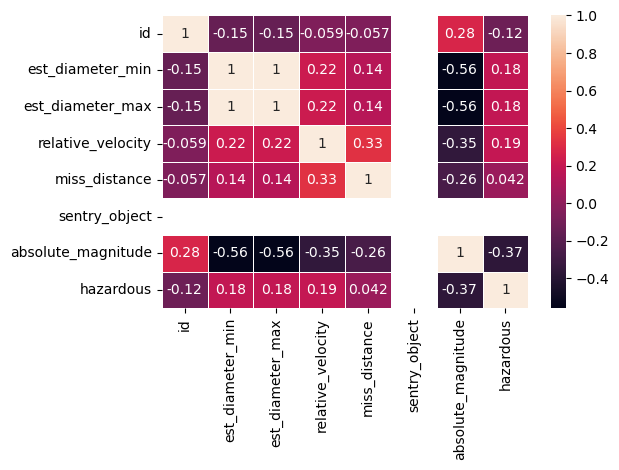

In [21]:
# Good old correleaiton matrix. This is part of initial exploration to see which values are irrelevant
# and which values we want to mess around with.

heat_map(df)
save_fig('heat_map')

In [22]:
# Now let's see the correleation between miss distance and the rest of the dataset
corr_sort(df, 'miss_distance')

C:\Users\Clay\AppData\Local\Temp\ipykernel_4776\2797817948.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_ = df.corr(method = method)


miss_distance         1.000000
relative_velocity     0.327169
est_diameter_min      0.142241
est_diameter_max      0.142241
hazardous             0.042302
id                   -0.056510
absolute_magnitude   -0.264168
sentry_object              NaN
Name: miss_distance, dtype: float64

In [23]:
# Absolute magnitude and the rest of the dataset

corr_sort(df, 'absolute_magnitude')

C:\Users\Clay\AppData\Local\Temp\ipykernel_4776\2797817948.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_ = df.corr(method = method)


absolute_magnitude    1.000000
id                    0.277258
miss_distance        -0.264168
relative_velocity    -0.353863
hazardous            -0.365267
est_diameter_max     -0.560188
est_diameter_min     -0.560188
sentry_object              NaN
Name: absolute_magnitude, dtype: float64

#### Scatter Plots

In [24]:

pair_plot(df, target)
save_fig('pair_plot')

## Experiments
### Differentiation between previous works and our work
In this report, we run multiple experiments chaning one variable at a time.
This makes it easy to replicate in other enviornments and if something happens to be wrong/needs to be changes, it's easy to do so.

### Experiment 00: Kaggle Base Model

This is a recreation of the Random Forest model from one of the existing [Kaggle](https://www.kaggle.com/code/elnahas/nasa-nearest-earth-objects/notebook) notebooks.

#### Preprocessing the Data

In [ ]:
'''
Like any good science experiment, we want to replicate what our peers have done and see if we get the
same results. Now what we want to do is replicate the random forest results from other notebooks.
Or just another notebook. Singular.
'''

#replicating this notebook: https://www.kaggle.com/code/elnahas/nasa-nearest-earth-objects/notebook

# First, we get rid of uneeded columns. Can't have strings
#It's best to make a copy of the OG dataframe in case you want to run other experiments later on.
exp_00 = df.copy()

exp_00X = exp_00.drop(columns = ['id', 'name', 'est_diameter_max', 'hazardous', 'miss_distance', 'absolute_magnitude', 'orbiting_body','sentry_object'], axis = 1)

In [ ]:
exp_00X.info()

In [ ]:
exp_00Y = exp_00.hazardous.astype('int')
print(exp_00X.shape, exp_00Y.shape)

#### Spitting the Data Set

In [ ]:
#AND now we split into train and test sets

exp00X_train, exp00X_test, exp00Y_train, exp00Y_test = train_test_split(exp_00X, exp_00Y, test_size = 0.2, random_state = random_state)

In [ ]:
#Making sure the dataset was split accordingly
print("OG size of dataset: ", df.shape[0])

print("Size of X training: ", exp00X_train.shape[0])

print("Size of X test: ", exp00X_test.shape[0])

print("Size of Y Training: ", exp00Y_train.shape[0])


print("Size of Y Test: ", exp00Y_test.shape[0])

#### Training the Random Forest Model

In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest = RandomForestClassifier()
random_forest.fit(exp00X_train, exp00Y_train)
random_forest_prediction = random_forest.predict(exp00X_test)
exp00_accuracy = round(accuracy_score(random_forest_prediction, exp00Y_test) * 100, 2)
print("Experiment 00 Random Forst Accuracy:", exp00_accuracy)

For Experiment 00, the accuracy was 89.39%

## Experiment 01: Our Base Model

This is our base model. This first thing we experiment with is keeping more data in the dataset. We only removed data that would have no effect on the model: name, id, orbiting body and 

In [ ]:
'''
Now we know what we have to beat. Or attempt to beat. Onwards to experiment 01
'''

#we grabbing the OG dataset
exp_01 = df.copy()

In [ ]:
#We confirming that this is the OG dataset. Turst but verify.
exp_01.info()

### Preprocessing the Data

In [ ]:
'''
We're going to clean up the data but not as much as experiment 00. I'm not sure what the other of the
other notebook was thinking but we balling
'''

exp_01 = drop(exp_01, 'id', 'name', 'orbiting_body', 'sentry_object')

exp_01_X = drop(exp_01, 'hazardous')

exp_01_Y = exp_01['hazardous']
exp_01Y = exp_01.hazardous.astype('int')

#### Splitting the Data Set

In [ ]:
#Experiment 01 will be the same as experiment 00 except we keeping all the features.

exp01X_train, exp01X_test, exp01Y_train, exp01Y_test = train_test_split(exp_01_X, exp_01Y, test_size = 0.2, random_state = random_state)

#### Exploring the Data Set

In [ ]:
exp01X_train.info()

In [ ]:
#Making sure the dataset was split accordingly
print("OG size of dataset: ", df.shape[0])

print("Size of X training: ", exp01X_train.shape[0])

print("Size of X test: ", exp01X_test.shape[0])

print("Size of Y Training: ", exp01Y_train.shape[0])

print("Size of Y Test: ", exp01Y_test.shape[0])

In [ ]:
exp01X_train.info()

#### Training the Model

In [ ]:
#And now the moment of truth

random_forest = RandomForestClassifier()
random_forest.fit(exp01X_train, exp01Y_train)
random_forest_prediction = random_forest.predict(exp01X_test)
exp01_accuracy  = round(accuracy_score(random_forest_prediction, exp01Y_test) * 100, 2)
print("Experiment 01 Random Forest Accuracy:", exp01_accuracy )

For Experiment 01, the accuracy was 91.95%

## Experiment 02: Logistic Regression

Experiement 02 is the same as Experiment 01, but with implementing logistic regresssion for comparative purposes. Cross validation and  $k$-fold validation are performed as well.
Since we saw an imporvement in keeping more data points, we wanted to see if adding cross validation would improve the model as well.

In [ ]:
# let's make this better. Or at least try to.

# Enter grid search aka k-fold validation
# Let's set up experiment 02, which will be like experiment 01, but with grid search

exp_02_X = exp_01_X.copy()
exp_02_Y = exp_01_Y.copy()

#exp_02Y = exp_02_Y.hazardous.astype('int')
exp_02_Y = exp_01.hazardous.astype('int')


#### Splitting the Data Set

In [ ]:

exp02X_train, exp02X_test, exp02Y_train, exp02Y_test = train_test_split(exp_02_X, exp_02_Y, test_size = 0.2, random_state=random_state)

#### Training the Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipeline_exp_02 = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_state, solver='lbfgs'))

pipeline_exp_02.fit(exp02X_train, exp02Y_train)
exp02_y_prediction = pipeline_exp_02.predict(exp02X_test)
exp02_accuracy = round(pipeline_exp_02.score(exp02X_test, exp02Y_test) * 100, 2)
print("Experiment 2 Logistic Regression Accuracy: ", exp02_accuracy)

#### Performing $k$-fold Validation

In [ ]:
# k-Fold cross-validation: Experiment 2
from sklearn.model_selection import StratifiedKFold

exp02_k_fold = StratifiedKFold(n_splits = 4)

scores = []
for k, (train, test) in enumerate(exp02_k_fold.split(exp02X_train, exp02Y_train)):
    X_train_k_fold, X_test_k_fold = exp02X_train.iloc[train], exp02X_train.iloc[test]
    y_train_k_fold, y_test_k_fold = exp02Y_train.iloc[train], exp02Y_train.iloc[test]

    pipeline_exp_02.fit(X_train_k_fold, y_train_k_fold)
    score = pipeline_exp_02.score(X_test_k_fold, y_test_k_fold)
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train_k_fold), score))

print('\nk-Fold Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

#### Performing Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipeline_exp_02,
                         X=X_train_k_fold,
                         y=y_train_k_fold,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross validation and $k$-fold analysis demonstrate the model's robustness, as shown by the consistently close accuracies across folds.

For Experiment 02, the accuracy was 90.2% +/- 0.3%

## Experiment 03: Random Oversampling

As depicted in the class distribution graph, there is a disproportionate representation of Near-Earth Objects (NEOs) classified as hazardous compared to those deemed non-hazardous.

This is another distinction between our experiments vs those performed on kaggle.

In [ ]:
exp_03 = exp_01.copy()

### Class Distribution Revisited

In [ ]:
hazardous_class_distribution = exp_03['hazardous'].value_counts()
print(hazardous_class_distribution)

In [ ]:
# False: 81,996
#True: 8,840
# looks like we have ourselve a case of unbalanced class distribution.
# we shall deal with this using random oversampling.
# first: splitting the dataset

exp_03_X = drop(exp_03, 'hazardous')

In [ ]:
exp_03_X.info()

In [ ]:
exp_03_Y = exp_03['hazardous']

In [ ]:
exp_03_Y.info()

In [ ]:
minority_class = exp_03[exp_03['hazardous'] == True]
majority_class = exp_03[exp_03['hazardous'] == False]

#### Performing Random Oversampling

In [ ]:
oversampled_minority = minority_class.sample(n=len(majority_class), replace=True, random_state=random_state)

In [ ]:
balanced_exp_03 = pd.concat([majority_class, oversampled_minority])

In [ ]:
balanced_exp_03 = balanced_exp_03.sample(frac = 1, random_state=random_state)

In [ ]:
balanced_exp_03.info()

#### Experiment A

##### Splitting the Data Set

In [ ]:
# Now that we've fixed the sampling, let's rerun
# experiment 01 & experiment 02 using the balanced dataset

#rerunning experiment 1

#Experiment 01 will be the same as experiment 00 except we keeping all the features.
#Let's call this experiment 03A

balanced_exp_03a_X = drop(balanced_exp_03, 'hazardous')
balanced_exp_03a_Y = balanced_exp_03['hazardous']

balanced_exp_03a_Y = balanced_exp_03.hazardous.astype('int')

exp03aX_train, exp03aX_test, exp03aY_train, exp03aY_test = train_test_split(balanced_exp_03a_X, balanced_exp_03a_Y, test_size = 0.2, random_state = random_state)

##### Training the Model

In [ ]:
# Ladies and gentlemen, we're back

#And now the moment of truth

random_forest = RandomForestClassifier()
random_forest.fit(exp03aX_train, exp03aY_train)

##### Evaluating the Model

In [ ]:
random_forest_prediction = random_forest.predict(exp03aX_test)
exp03a_accuracy = round(accuracy_score(random_forest_prediction, exp03aY_test) * 100, 2)
print("Experiment 03A Random Forest Accuracy:", exp03a_accuracy)

For Experiment 03A, the accuracy was 96.68%

#### Experiment B

##### Splitting the Data Set

In [ ]:
#Onwards to experiment 3B
#NOTE: Experiment 3B is meant to be grid search for random forest with a balanced dataset.
#For some reason it's taking forever to run so I will run it at the end, time permitting.
#So we move onto experiment 4, feature engineering.
#4A will be feature engineering with unbalanced dataset
#4B will be feature engineering with balanced dataset

balanced_exp_03b_X = drop(balanced_exp_03, 'hazardous')
balanced_exp_03b_Y = balanced_exp_03['hazardous']

balanced_exp_03b_Y = balanced_exp_03.hazardous.astype('int')

exp03bX_train, exp03bX_test, exp03bY_train, exp03bY_test = train_test_split(balanced_exp_03b_X, balanced_exp_03b_Y, test_size = 0.2, random_state = random_state)

##### Grid Search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline with StandardScaler and RandomForestClassifier
pipeline_exp_03b_best = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=100, random_state=random_state))

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'randomforestclassifier__max_depth': [5, 10, 20],       # Maximum depth of the tree
    'randomforestclassifier__min_samples_split': [2, 5, 10]    # Minimum number of samples required to split a node
}

grid_search = GridSearchCV(pipeline_exp_03b, param_grid, cv=5, n_jobs=-1)

grid_search.fit(exp03bX_train, exp03bY_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

exp03b_y_prediction = best_estimator.predict(exp03bX_test)

exp03b_accuracy = round(best_estimator.score(exp03bX_test, exp03bY_test) * 100, 2)

print("Test Accuracy:", exp03b_accuracy)

print("Best Parameters:", best_params)

##### $k$-Fold Validation

Performing $k$-fold validation using the best parameters from the grid search.

In [ ]:
# k-Fold cross-validation: Experiment 3b
from sklearn.model_selection import StratifiedKFold

exp03b_k_fold = StratifiedKFold(n_splits = 4)

pipeline_exp_03b_best = make_pipeline(StandardScaler(), RandomForestClassifier(**best_params, random_state=random_state))


scores = []
for k, (train, test) in enumerate(exp03b_k_fold.split(exp03bX_train, exp03bY_train)):
    X_train_k_fold, X_test_k_fold = exp03bX_train.iloc[train], exp03bX_train.iloc[test]
    y_train_k_fold, y_test_k_fold = exp03bY_train.iloc[train], exp03bY_train.iloc[test]

    pipeline_exp_03b_best.fit(X_train_k_fold, y_train_k_fold)
    score = pipeline_exp_03b_best.score(X_test_k_fold, y_test_k_fold)
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train_k_fold), score))

print('\nk-Fold Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

##### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipeline_exp_03b_best,
                         X=X_train_k_fold,
                         y=y_train_k_fold,
                         cv=10,
                         n_jobs=1)

print('CV Accuracy Scores: %s' % scores)

print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

## Experiment 04: Feature Engineering

In these pairs of experiments, we use feature engineering to average out the min and max estimated diameters of the NEOS.

Experiment 04A uses the unbalanced dataset
Experiment 04B uses the balanced dataset

### Experiment A

Experiment A entails creating a new feature and logarithmically transforming it, while dealing with an unbalanced dataset (original).

In [ ]:
#Experiment 4A: Feature engineering w/ unbalanced dataset

exp_04A = exp_03.copy()

In [ ]:
exp_04A.info()

#### Averaging Estimated Diameters as a new Feature

In [ ]:
#Feature engineering

from sklearn.preprocessing import FunctionTransformer

exp_04A['est_diameter_avg'] = exp_04A[['est_diameter_min', 'est_diameter_max']].mean(axis=1)
exp_04A.drop(['est_diameter_min', 'est_diameter_max'], axis=1, inplace=True)

In [ ]:
exp_04A.info()

#### Log Transformation on the new Feature

In [ ]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_estDiameter = log_transformer.transform(exp_04A[['est_diameter_avg']])

#### Splitting the Data Set

In [ ]:
exp_04A_X = drop(exp_04A, 'hazardous')
exp_04A_Y = exp_04A['hazardous']

exp_04A_Y = exp_04A.hazardous.astype('int')

In [ ]:
exp04aX_train, exp04aX_test, exp04aY_train, exp04aY_test = train_test_split(exp_04A_X, exp_04A_Y, test_size = 0.2, random_state = random_state)

#### Training a Random Forest Model

In [ ]:
random_forest = RandomForestClassifier()
random_forest.fit(exp04aX_train, exp04aY_train)
random_forest_prediction = random_forest.predict(exp04aX_test)
exp04a_accuracy = round(accuracy_score(random_forest_prediction, exp04aY_test) * 100, 2)
print("Experiment 04A Random Forest Accuracy:", exp04a_accuracy)

### Experiment B

Experiment B entails creating a the same feature (estimated_average_diameter) and logarithmically transforming it from Experiment A, but dealing with a balanced dataset.

In [ ]:
#Experiment 04A Random Forest Accuracy: 91.61%

#Onwards to 04B: Same as 04A except using the balanced dataset 0f 03

exp_04B = balanced_exp_03.copy()

#### Averaging Estimated Diameters as a new Feature

This is the same as Experiment 04: A.

In [ ]:
exp_04B['est_diameter_avg'] = exp_04B[['est_diameter_min', 'est_diameter_max']].mean(axis=1)
exp_04B.drop(['est_diameter_min', 'est_diameter_max'], axis=1, inplace=True)

#### Log Transformation on the new Feature

This is the same as Experiment 04: A.

In [ ]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_estDiameter = log_transformer.transform(exp_04B[['est_diameter_avg']])

#### Splitting the Data Set

In [ ]:
exp_04B_X = drop(exp_04B, 'hazardous')
exp_04B_Y = exp_04B['hazardous']

exp_04B_Y = exp_04B.hazardous.astype('int')

In [ ]:
exp04bX_train, exp04bX_test, exp04bY_train, exp04bY_test = train_test_split(exp_04B_X, exp_04B_Y, test_size = 0.2, random_state = random_state)

#### Training a Random Forest Model

In [ ]:
random_forest = RandomForestClassifier()
random_forest.fit(exp04bX_train, exp04bY_train)
random_forest_prediction = random_forest.predict(exp04bX_test)
exp04b_accuracy = round(accuracy_score(random_forest_prediction, exp04bY_test) * 100, 2)

print("Experiment 04B Random Forest Accuracy", exp04b_accuracy)

#### Grid Search

Let's determine the best model parameters for our best performing model. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline with StandardScaler and RandomForestClassifier
pipeline_exp_04b = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=random_state))

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'randomforestclassifier__max_depth': [5, 10, 20],       # Maximum depth of the tree
    'randomforestclassifier__min_samples_split': [2, 5, 10]    # Minimum number of samples required to split a node
}

grid_search = GridSearchCV(pipeline_exp_03b, param_grid, cv=5, n_jobs=-1)

grid_search.fit(exp03bX_train, exp03bY_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

exp04b_y_prediction = best_estimator.predict(exp04bX_test)

best_accuracy = round(best_estimator.score(exp04bX_test, exp04bY_test) * 100, 2)

print("Best Test Accuracy:", best_accuracy)

print("Best Parameters:", best_params)

## Comparing the Results

In [ ]:
print("Experiment 00 Random Forest Accuracy:", exp00_accuracy )

print("Experiment 01 Random Forest Accuracy:", exp01_accuracy )

print("Experiment 02 Logistic Regression Accuracy: ", exp02_accuracy)

print("Experiment 03A Test Accuracy:", exp03a_accuracy)

print("Experiment 03B Test Accuracy:", exp03b_accuracy)

print("Experiment 04A Random Forest Accuracy:", exp04a_accuracy)

print("Experiment 04B Random Forest Accuracy", exp04b_accuracy)

## Our Best Performing Model

Our best performing model is from Experiment 04B, utilizing a Random Forest algorithm that incorporates a newly engineered feature, 'estimated_average_diameter,' scaled logarithmically, and with an evenly distributed class representation. Aftering performing grid search, we got the follow accuracy score with the best paramaters:

In [ ]:
best_params

In [ ]:
best_accuracy